In [975]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)


sys.path.append('../')
import xai
reload(xai)
import xai

In [976]:
csv_path = 'data/adult.data'
categorical_cols = ["gender", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "native-country", "loan"]
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]

In [977]:
df = pd.read_csv(csv_path, names=csv_columns)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [978]:
target = "loan"
protected = ["gender", "ethnicity", "native-country", "age"]

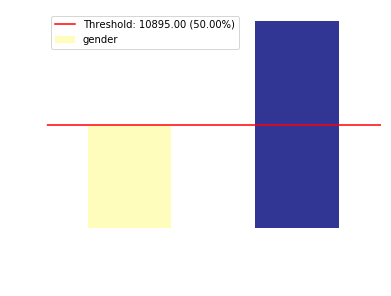

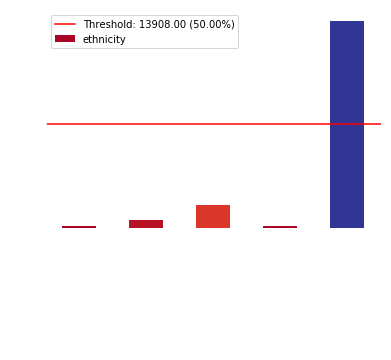

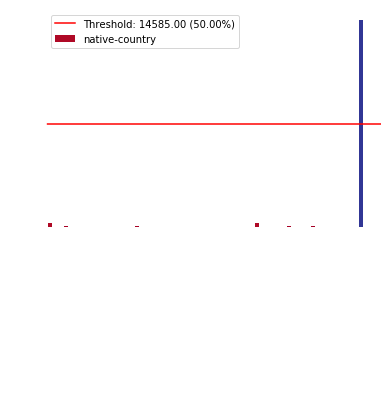

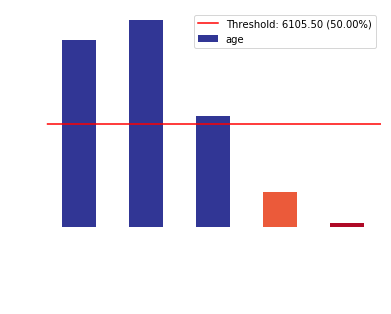

In [979]:
ims = xai.show_imbalances(df, protected)

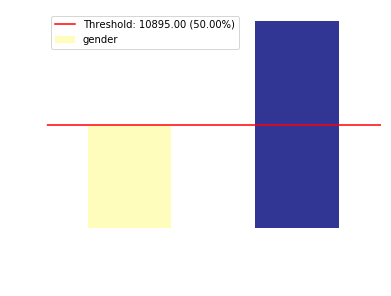

In [980]:
im = xai.show_imbalance(df, "gender")

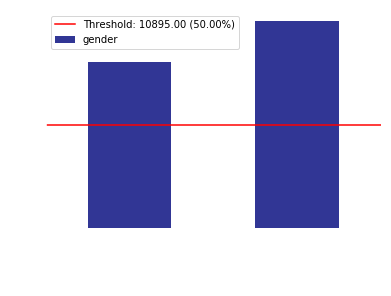

In [981]:
bal_df = xai.balance(df, "gender", upsample=0.8)

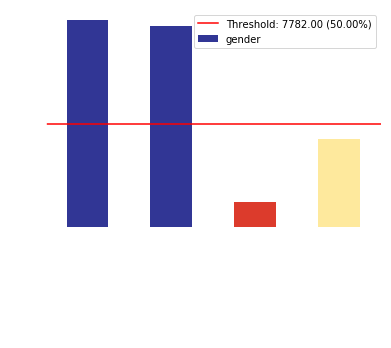

In [982]:
im = xai.show_imbalance(bal_df, "gender", cross=["loan"])

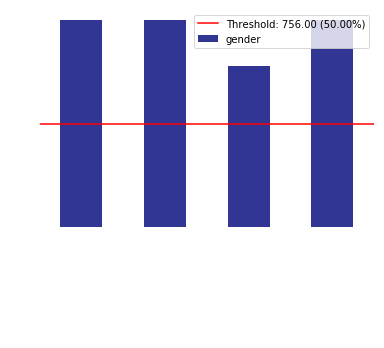

(5715, 15)

In [997]:
bal_df = xai.balance(df, "gender", cross=["loan"], upsample=0, downsample=0.1)
bal_df.shape

In [998]:

proc_df = xai.normalize_numeric(bal_df)
proc_df = xai.convert_categories(proc_df)
x = proc_df.drop("loan", axis=1)
y = proc_df["loan"]

x_train, y_train, x_test, y_test = xai.balanced_train_test_split(
            x, y, cross=["gender"], 
            categorical_cols=categorical_cols, min_per_class=300,
            fallback_type="half")

print(x_test.shape)

(1200, 14)


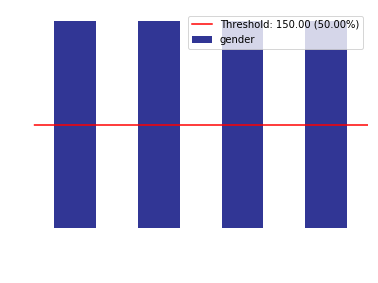

In [999]:
df_test = x_test.copy()
df_test["loan"] = y_test

_= xai.show_imbalance(df_test, "gender", cross=["loan"], categorical_cols=categorical_cols)

In [1000]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, roc_curve, auc

from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding

def build_model(X):
    input_els = []
    encoded_els = []
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    for k,dtype in dtypes:
        input_els.append(Input(shape=(1,)))
        if dtype == "int8":
            e = Flatten()(Embedding(X[k].max()+1, 1)(input_els[-1]))
        else:
            e = input_els[-1]
        encoded_els.append(e)
    encoded_els = concatenate(encoded_els)

    layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
    out = Dense(1, activation='sigmoid')(layer1)

    # train model
    model = Model(inputs=input_els, outputs=[out])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model


def f_in(X, m=None):
    """Preprocess input so it can be provided to a function"""
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_out(probs, threshold=0.5):
    """Convert probabilities into classes"""
    return list((probs >= threshold).astype(int).T[0])


In [1001]:
model = build_model(proc_df.drop("loan", axis=1))

model.fit(f_in(x_train), y_train, epochs=50, batch_size=512)

Epoch 1/50
4515/4515 [==============================] - 2s 535us/step - loss: 0.6674 - acc: 0.5967
Epoch 2/50
4515/4515 [==============================] - 0s 7us/step - loss: 0.6356 - acc: 0.6487
Epoch 3/50
4515/4515 [==============================] - 0s 7us/step - loss: 0.6031 - acc: 0.6788
Epoch 4/50
4515/4515 [==============================] - 0s 7us/step - loss: 0.5771 - acc: 0.7096
Epoch 5/50
4515/4515 [==============================] - 0s 6us/step - loss: 0.5636 - acc: 0.7205
Epoch 6/50
4515/4515 [==============================] - 0s 6us/step - loss: 0.5494 - acc: 0.7267
Epoch 7/50
4515/4515 [==============================] - 0s 7us/step - loss: 0.5349 - acc: 0.7369
Epoch 8/50
4515/4515 [==============================] - 0s 7us/step - loss: 0.5262 - acc: 0.7355
Epoch 9/50
4515/4515 [==============================] - 0s 7us/step - loss: 0.5148 - acc: 0.7442
Epoch 10/50
4515/4515 [==============================] - 0s 6us/step - loss: 0.5001 - acc: 0.7561
Epoch 11/50
4515/4515 [====

In [1002]:
score = model.evaluate(f_in(x_test), y_test, verbose=1)
print("Error %.4f: " % score[0])
print("Accuracy %.4f: " % (score[1]*100))

1200/1200 [==============================] - 1s 847us/step
Error 0.3471: 
Accuracy 83.8333: 


In [1003]:
probabilities = model.predict(f_in(x_test))
pred = f_out(probabilities)

../xai/__init__.py:340: RuntimeWarning: invalid value encountered in long_scalars
  specificity = TN / (TN+FP)
../xai/__init__.py:339: RuntimeWarning: invalid value encountered in long_scalars
  recall = TP / (TP+FN)
../xai/__init__.py:338: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP / (TP+FP)


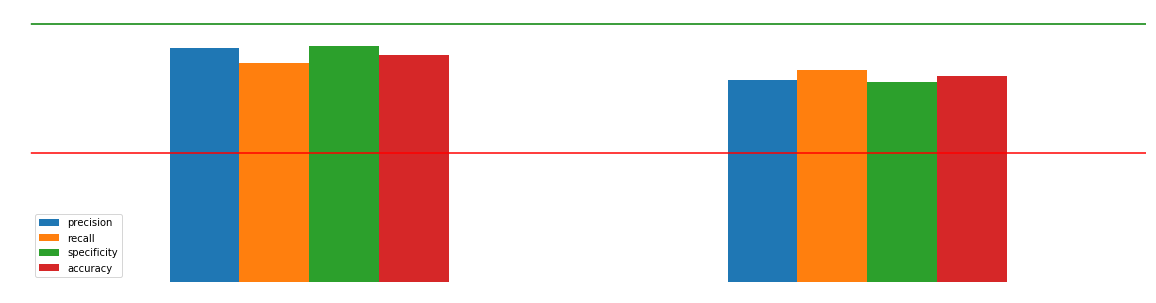

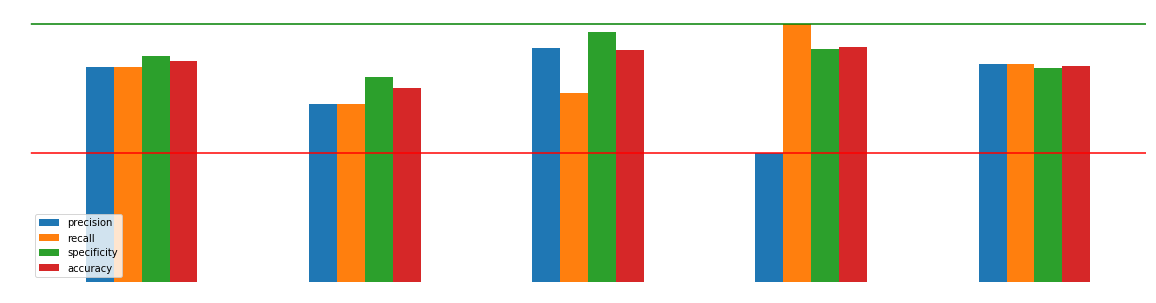

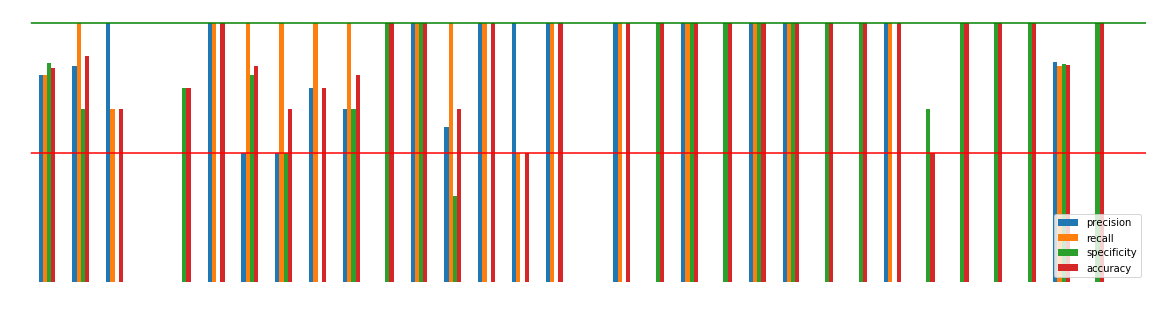

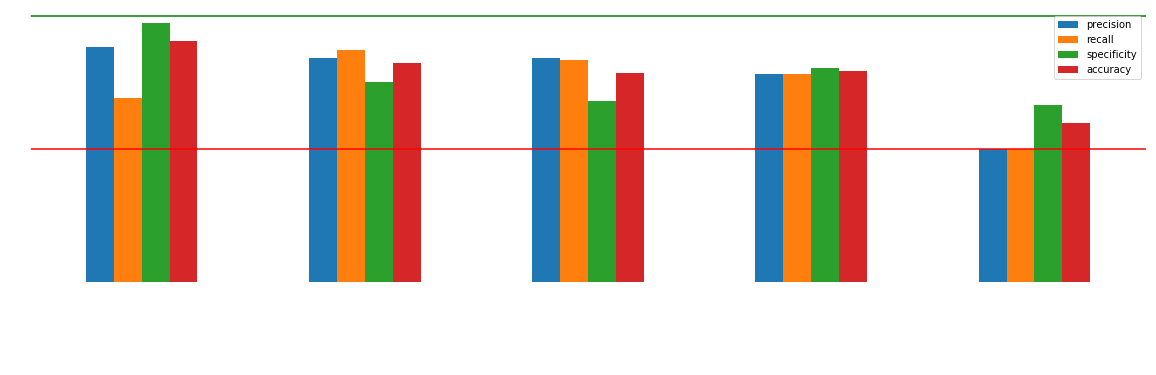

In [1004]:
_= xai.metrics_imbalances(
        x_test, 
        y_test, 
        probabilities,
        columns=protected,
        categorical_cols=categorical_cols)

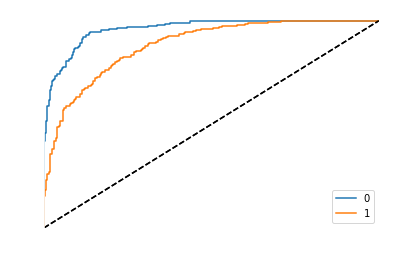

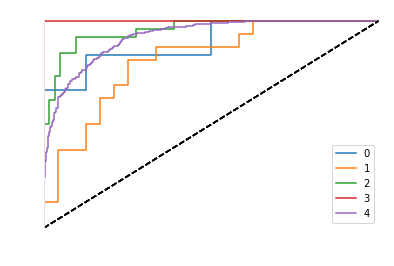

/home/alejandro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/alejandro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


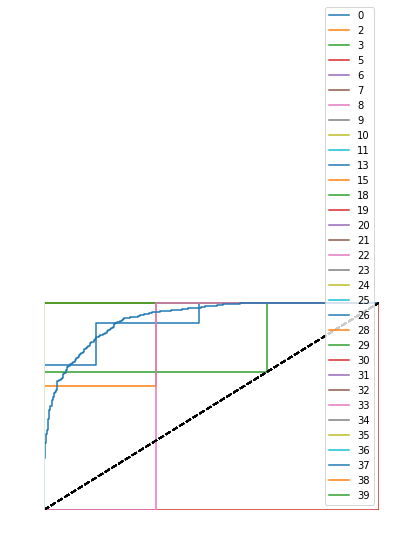

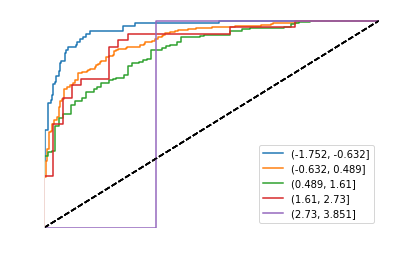

In [1005]:
_= xai.roc_imbalances(
    x_test, 
    y_test, 
    probabilities, 
    columns=protected,
    categorical_cols=categorical_cols)

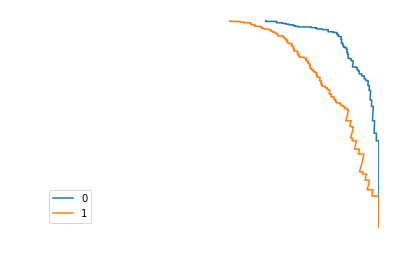

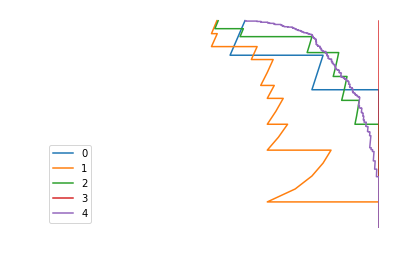

/home/alejandro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


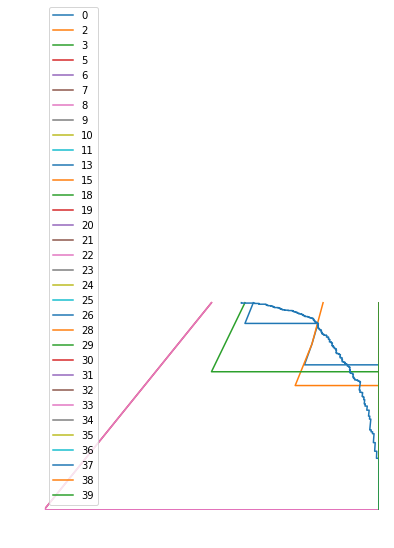

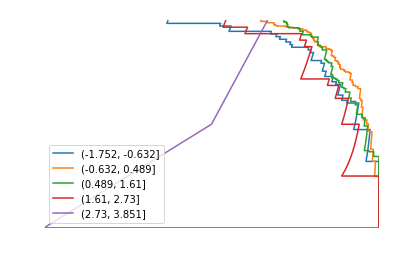

In [1006]:
_= xai.pr_imbalances(
    x_test, 
    y_test, 
    probabilities, 
    columns=protected,
    categorical_cols=categorical_cols)

/home/alejandro/.local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


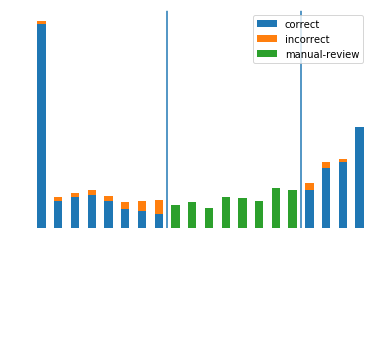

In [1050]:

def convert_probs(probs, threshold=0.5):
    """Convert probabilities into classes"""
    # TODO: Enable for multiclass
    return (probs >= threshold).astype(int).flatten()


def smile_imbalance(
        y_test, 
        probs, 
        threshold=0.5, 
        manual_review=None,
        display_breakdown=False,
        bins=10):
    
    preds = convert_probs(probabilities, threshold)
    d = pd.DataFrame(probabilities)
    d.columns = ["probs"]
    d["preds"] = preds
    d["target"] = y_test

    tps = np.full(y_test.shape, False, bool)

    d["tps"] = np.full(y_test.shape[0], False, bool)
    d["tns"] = np.full(y_test.shape[0], False, bool)
    d["fps"] = np.full(y_test.shape[0], False, bool)
    d["fns"] = np.full(y_test.shape[0], False, bool)
    d["manual-review"] =  np.full(y_test.shape[0], False, bool)

    d["tps"].loc[y_test == 1] = preds[y_test == 1] == 1
    d["tns"].loc[y_test == 0] = preds[y_test == 0] == 0
    d["fps"].loc[y_test == 0] = preds[y_test == 0] == 1
    d["fns"].loc[y_test == 1] = preds[y_test == 1] == 0

    d["correct"] = d["tps"].values
    d["correct"].loc[d["tns"] == 1] = True

    d["incorrect"] = d["fps"].values
    d["incorrect"].loc[d["fns"] == 1] = True 
    
    if display_breakdown:
        disp_cols = ["tps", "tns", "fps", "fns"]
    else:
        disp_cols = ["correct", "incorrect"]
    
    if manual_review:
        gt = probabilities > manual_review
        lt = probabilities < threshold
        d["manual-review"] = gt * lt > 0
        
        if display_breakdown:
            d["tps"].loc[d["manual-review"]] = False
            d["tns"].loc[d["manual-review"]] = False
            d["fps"].loc[d["manual-review"]] = False
            d["fns"].loc[d["manual-review"]] = False
        else:
            d["correct"].loc[d["manual-review"]] = False
            d["incorrect"].loc[d["manual-review"]] = False
        
        disp_cols.append("manual-review")

    d["tps"] = d["tps"].astype(int) 
    d["tns"] = d["tns"].astype(int)
    d["fps"] = d["fps"].astype(int)
    d["fns"] = d["fns"].astype(int)
    d["correct"] = d["correct"].astype(int)
    d["incorrect"] = d["incorrect"].astype(int)

    grouped = xai.group_by_columns(d, ["probs"], bins=bins)

    ax = grouped[disp_cols].sum().plot.bar(stacked=True)
    lim = ax.get_xlim()
    ran = lim[1] - lim[0]
    thre = ran*threshold + lim[0]
    manr = ran*manual_review + lim[0]
    plt.axvline(thre)
    plt.axvline(manr)
    
    return d
    
d = smile_imbalance(
    y_test, 
    probabilities,
    bins=21,
    threshold=0.8,
    manual_review=0.4)


In [1055]:
d.sum()

probs            577.384597
preds            359.000000
target           600.000000
tps              339.000000
tns              580.000000
fps               20.000000
fns              261.000000
manual-review    297.000000
correct          815.000000
incorrect         88.000000
dtype: float64

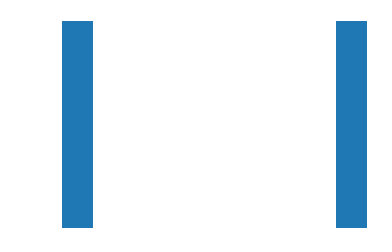

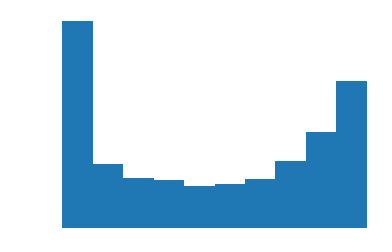

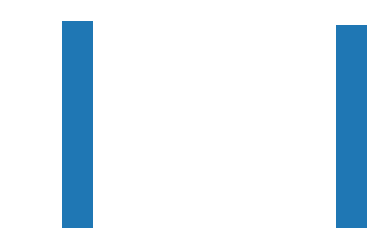

In [1008]:
d["target"].plot.hist(bins=10)
plt.show()
d["probs"].plot.hist(bins=10)
plt.show()
d["preds"].plot.hist(bins=10)